In [9]:
# Model was not trained on: (which are the test data) 
# - individual 1
# - individual 8
# - individual 11

test_df.iloc[2000]

Unnamed: 0                             2000
individual_id                             1
expression_id                             2
individual_name    FaceTalk_170811_03275_TA
expression_name                   bareteeth
Name: 2000, dtype: object

In [2]:
import pandas as pd
import numpy as np
import hdbscan
import umap

In [3]:
#!pip install hdbscan
#!pip install umap-learn

In [4]:
test_df = pd.read_csv("data/test_nasi_metadata.csv")
train_df = pd.read_csv("data/train_nasi_metadata.csv")

In [5]:
test_latents = np.load("data/new_ground_truth/test_latents_nasi_gt.npy")
train_latents = np.load("data/new_ground_truth/train_latents_nasi_gt.npy")

In [6]:
print(f"Test latents shape: {test_latents.shape}, train latents shape: {train_latents.shape}")

Test latents shape: (4319, 16), train latents shape: (16146, 16)


In [7]:
print(f"Test dataframe shape: {test_df.shape}, train dataframe shape: {train_df.shape}")
assert test_df.shape[0] == test_latents.shape[0]
assert train_df.shape[0] == train_latents.shape[0]

Test dataframe shape: (4319, 5), train dataframe shape: (16146, 5)


In [8]:
test_df.iloc[[5]]

,Unnamed: 0,individual_id,expression_id,individual_name,expression_name
5,5,0,0,FaceTalk_170908_03277_TA,lips_up


In [9]:
#train_df.iloc[[5]]
all_df = pd.concat([train_df, test_df])

In [10]:
all_df.shape

(20465, 5)

In [11]:
#all_df.tail(10)

In [12]:
all_latents = np.vstack((train_latents, test_latents))

In [13]:
assert (all_latents[1] == train_latents[1]).all()

I do clustering here, instead of loading preprocessed data

Silhouette method for number of clusters

In [14]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm

In [ ]:
calculate_num_clusters = False
if calculate_num_clusters:
    sil = []
    kmax = 150

    Sum_of_squared_distances = [] #for elbow method
    ks = range(2, kmax+1)
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in tqdm(ks):
      kmeans = KMeans(n_clusters = k).fit(all_latents)
      labels = kmeans.labels_
      sil.append(silhouette_score(all_latents, labels, metric = 'euclidean'))
      Sum_of_squared_distances.append(kmeans.inertia_) #for elbow method

In [ ]:
max(labels)
plt.plot(range(2, kmax+1),sil, scalex=True, scaley=True, data=None)
plt.title("Silouhette score")


In [130]:
cluster = KMeans(n_clusters = 12).fit(all_latents)


Elbow method for number of clusters

In [ ]:
len(Sum_of_squared_distances)

In [ ]:
len(ks)

In [ ]:

plt.plot(ks, Sum_of_squared_distances)
#plt.plot(range(2, kmax+1),Sum_of_squared_distances, scalex=True, scaley=True, data=None)

plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

In [23]:
cluster = hdbscan.HDBSCAN(min_cluster_size=200,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(all_latents)
#for now it was trial and error, however the correct "minclustersize" can be calculated using some trials

In [24]:
max(cluster.labels_)

12

In [25]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
def plotClusters(funClusters, latents):
    umap_data = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.0, metric='cosine').fit_transform(latents)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = funClusters.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(10, 7))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
    plt.colorbar()
    plt.title("Visualization of one instance of clustering through HDBSCAN")

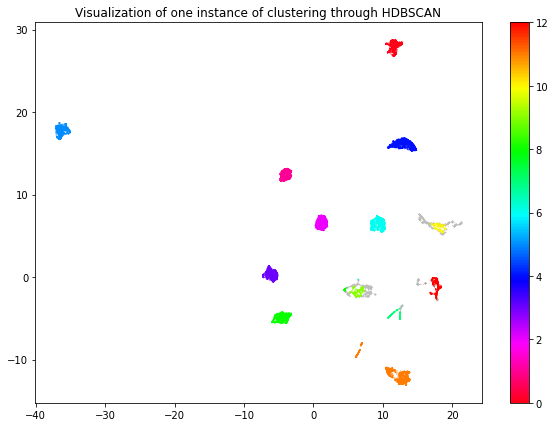

In [26]:
plotClusters(cluster, all_latents)

Now I try clustering with dimensionality reduction

In [27]:
'''umap_embeddings = umap.UMAP(n_neighbors=100, 
                            n_components=5, 
                            metric='cosine').fit_transform(all_latents)

cluster = hdbscan.HDBSCAN(min_cluster_size=60,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)'''

"umap_embeddings = umap.UMAP(n_neighbors=100, \n                            n_components=5, \n                            metric='cosine').fit_transform(all_latents)\n\ncluster = hdbscan.HDBSCAN(min_cluster_size=60,\n                          metric='euclidean',                      \n                          cluster_selection_method='eom').fit(umap_embeddings)"

In [28]:
max(cluster.labels_)

12

**What is the algorithm clustering?**

**Q: if k = 12, or minimum cluster size is s.t. clusters = 12 in hdbscan, will the clusters correspond to the different individuals?**

In [29]:
#all_df.insert(1, "clust_labels", cluster.labels_)

In [30]:
all_df.tail(100)

,Unnamed: 0,individual_id,expression_id,individual_name,expression_name
4219,4219,2,11,FaceTalk_170725_00137_TA,mouth_middle
4220,4220,2,11,FaceTalk_170725_00137_TA,mouth_middle
4221,4221,2,11,FaceTalk_170725_00137_TA,mouth_middle
4222,4222,2,11,FaceTalk_170725_00137_TA,mouth_middle
4223,4223,2,11,FaceTalk_170725_00137_TA,mouth_middle
...,...,...,...,...,...
4314,4314,2,11,FaceTalk_170725_00137_TA,mouth_middle
4315,4315,2,11,FaceTalk_170725_00137_TA,mouth_middle
4316,4316,2,11,FaceTalk_170725_00137_TA,mouth_middle
4317,4317,2,11,FaceTalk_170725_00137_TA,mouth_middle


In [31]:
clusters_lists = [set() for i in range(max(cluster.labels_)+1)]
individuals_lists = [set() for i in range(all_df["individual_id"].max()+1)]
#I want to make sets of clusters labels, individuals ids and more if necessary (e.g. expressions?)
individuals_ids = all_df["individual_id"].tolist()
for i in range(len(cluster.labels_)):
    if cluster.labels_[i] != -1:
        clusters_lists[cluster.labels_[i]].add(i)
    individuals_lists[individuals_ids[i]].add(i)

In [54]:
#individuals_lists[11]

In [33]:
max(cluster.labels_)

12

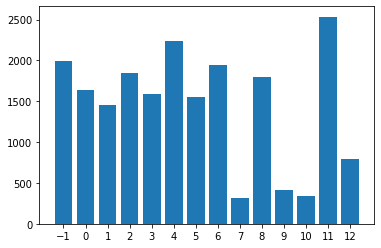

In [34]:
arr = np.array(cluster.labels_)

labels, counts = np.unique(arr, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

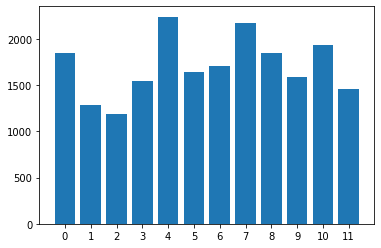

In [35]:
arr = np.array(individuals_ids)

labels, counts = np.unique(arr, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

In [36]:
IoUs = np.zeros((len(clusters_lists), len(individuals_lists)))

In [37]:
IoUs.shape

(13, 12)

In [38]:
for i in range(len(clusters_lists)):
    for j in range(len(individuals_lists)): 
        intersection = len(individuals_lists[j].intersection(clusters_lists[i]))
        union = len(individuals_lists[j].union(clusters_lists[i]))
        IoUs[i][j] = intersection/union
        #print(f"IoU {i,j} is {intersection/union}")


In [39]:
test_df.iloc[2000]
print(IoUs)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0

Text(33.0, 0.5, 'Cluster')

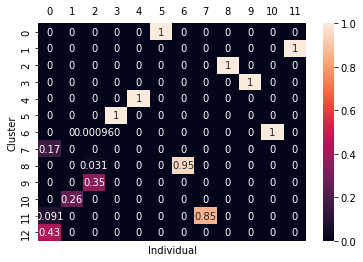

In [40]:
import seaborn as sns
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax = sns.heatmap(IoUs, annot=True)
ax.set_xlabel("Individual")
ax.set_ylabel("Cluster")

Another trial could be doing the percentage of "correct guesses" 
i.e. for each element of a cluster, check if the element is in the individuals set, if so, increment and calculate percentage

In [41]:
percentages = np.zeros((len(clusters_lists), len(individuals_lists)))
for i in range(len(clusters_lists)):
    for j in range(len(individuals_lists)): 
        for cluster_item in clusters_lists[i]:
            if cluster_item in individuals_lists[j]:
                percentages[i][j] += 1
        percentages[i][j] /= len(clusters_lists[i])
        


Text(33.0, 0.5, 'Cluster')

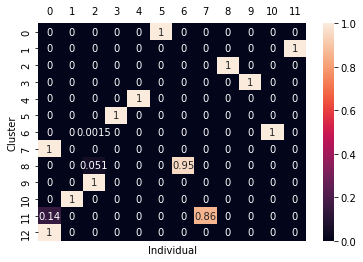

In [42]:
import seaborn as sns
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax = sns.heatmap(percentages, annot=True)
ax.set_xlabel("Individual")
ax.set_ylabel("Cluster")

### Constraining less the number of elements for HDBSCAN
What if each cluster, without constraining HDBSCAN's minimum number of elements for a cluster, is exactly the combination of an individual and one expression? 

In [43]:
cluster = hdbscan.HDBSCAN(min_cluster_size=30,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(all_latents)
#print(max(cluster.labels_))

22


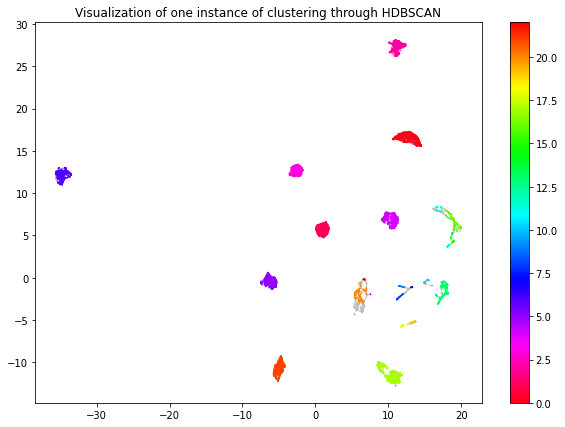

In [44]:
plotClusters(cluster, all_latents)

In [45]:
#len(set((all_df['individual_id'].map(str) + "-" + all_df['expression_id'].map(str)).tolist()))

In [46]:
all_df = all_df.reset_index()

In [47]:
#all_df.index.tolist()[20000:]

In [48]:
sets_dict = {}
for i in range(all_df['individual_id'].nunique()):
    for j in range(all_df['expression_id'].nunique()): 
        sets_dict[str(i)+"-"+str(j)] = set((all_df.loc[all_df['individual_id'] == i].index).tolist()).intersection(set((all_df.loc[all_df['expression_id'] == j].index).tolist()))

#format: i-j => individual i and expression j
#print(sets_dict['3-0'])

#TODO: intersection over union and heatmap for each cluster

In [53]:
#print(sets_dict)

In [50]:
clusters_lists = [set() for i in range(max(cluster.labels_)+1)]
#I want to make sets of clusters labels, individuals ids and more if necessary (e.g. expressions?)
for i in range(len(cluster.labels_)):
    if cluster.labels_[i] != -1:
        clusters_lists[cluster.labels_[i]].add(i)

In [51]:
IoUs = np.zeros((len(clusters_lists), len(sets_dict)))
for i in range(len(clusters_lists)):
    j = 0
    for item in sets_dict: 
        intersection = len(sets_dict[item].intersection(clusters_lists[i]))
        union = len(sets_dict[item].union(clusters_lists[i]))
        IoUs[i][j] = intersection/union
        j += 1
        #print(f"IoU {i,j} is {intersection/union}")


Text(292.5, 0.5, 'Cluster')

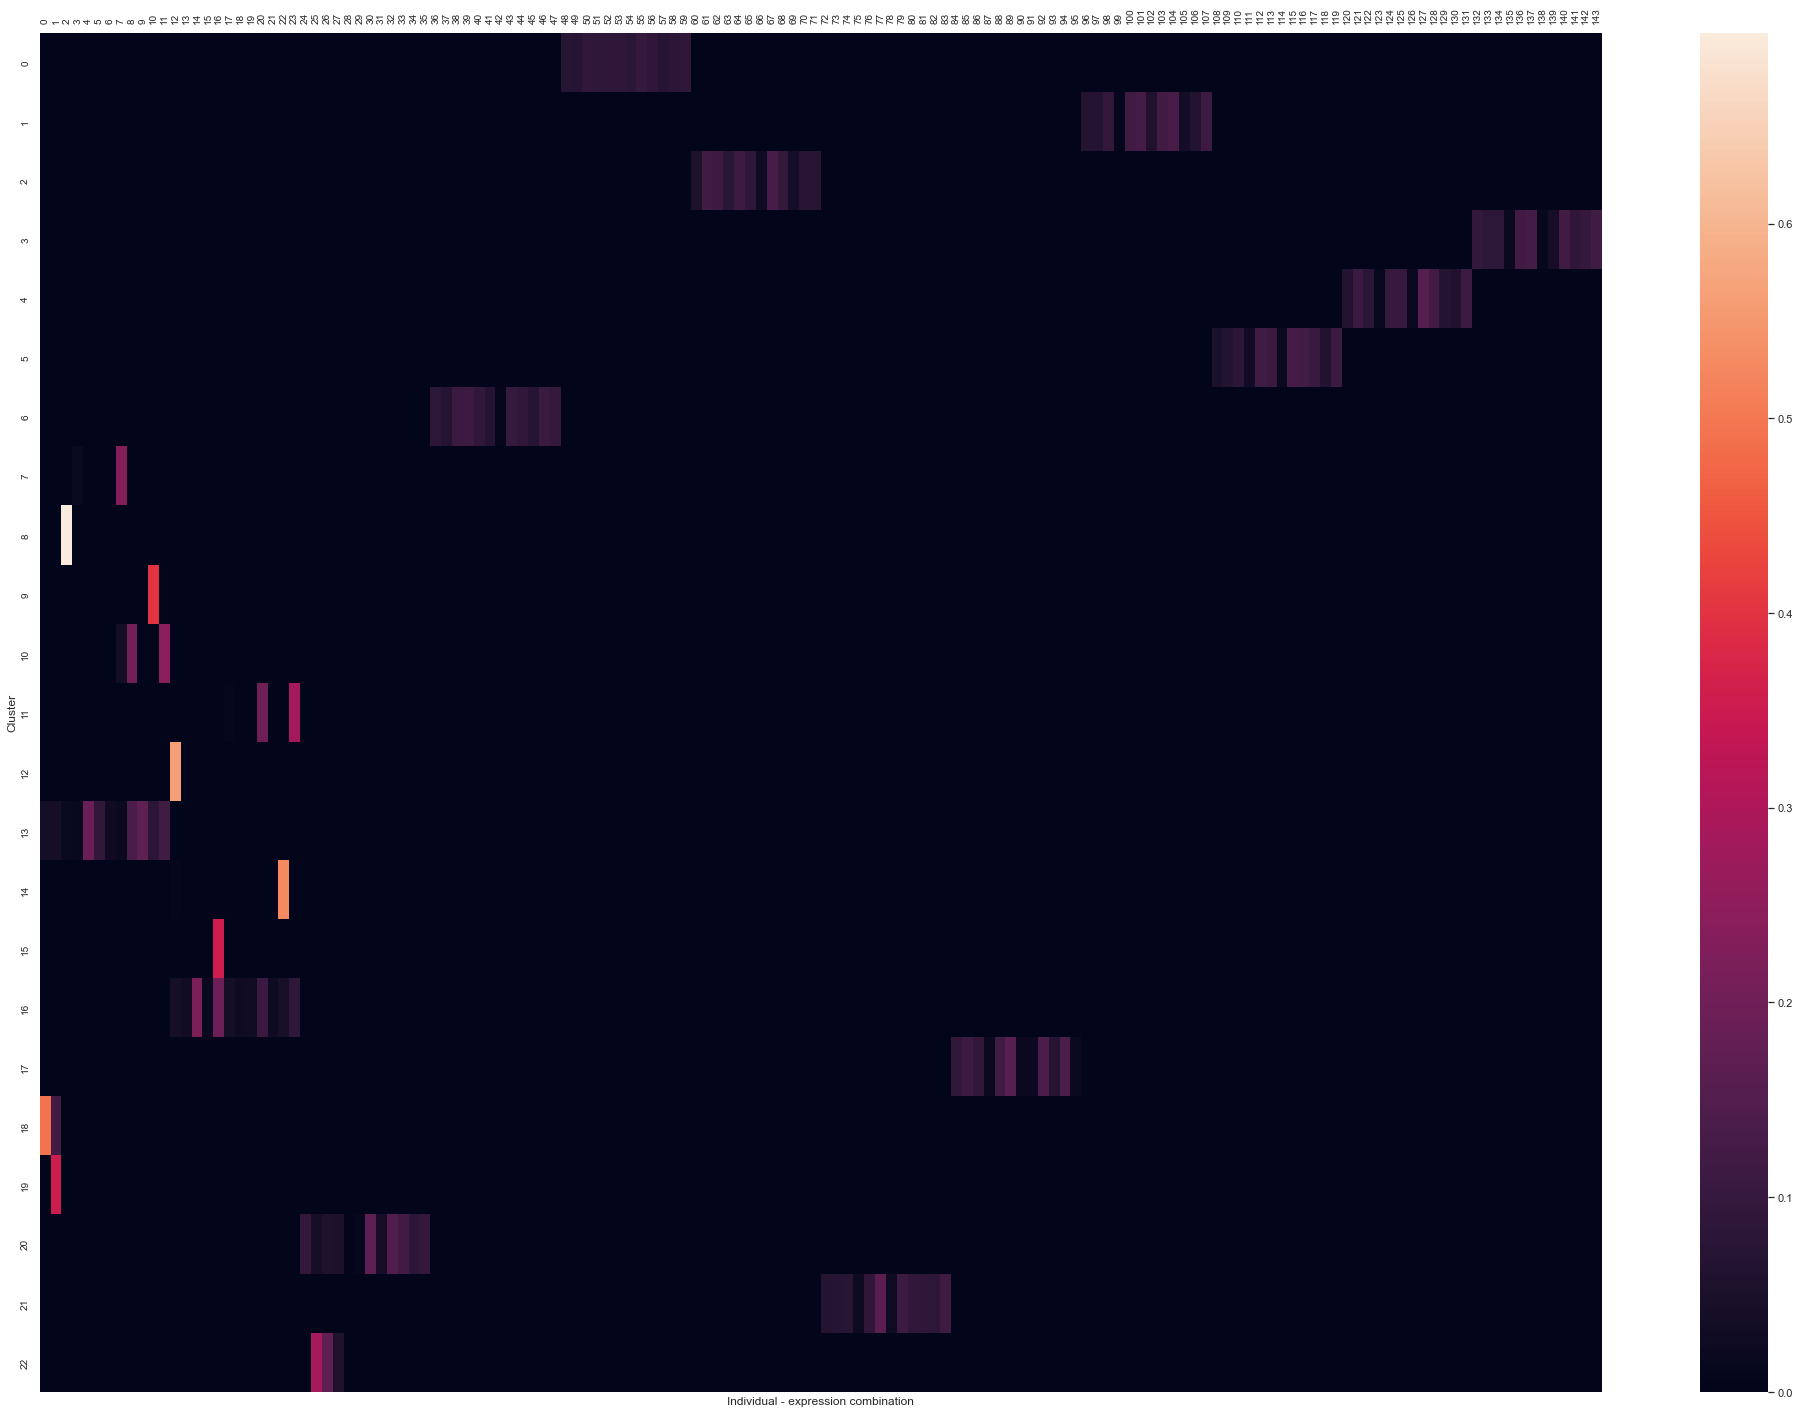

In [52]:
import seaborn as sns
sns.set(rc={'figure.figsize':(35,25)})
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax = sns.heatmap(IoUs, annot=False)
ax.set_xlabel("Individual - expression combination")
ax.set_ylabel("Cluster")